<a href="https://colab.research.google.com/github/alec-gironda/Pokemon-Variational-Autoencoder/blob/main/VAE_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import torchvision

#from .types_ import *


torch.Size([819, 3, 256, 256])


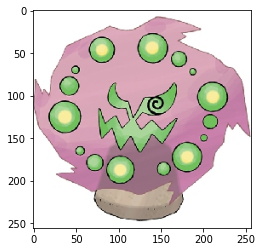

In [ ]:
num_pokemon = len(os.listdir("drive/MyDrive/data/pokemon_jpg/pokemon_jpg"))

ims = []

for im_name in os.listdir("drive/MyDrive/data/pokemon_jpg/pokemon_jpg"):
    s = (f"drive/MyDrive/data/pokemon_jpg/pokemon_jpg/{str(im_name)}")
    curr = torchvision.io.read_image(s)
    ims.append(curr)

ims = torch.stack(ims)
print(ims.shape)

# ims = ims[:,1,:,:]

ims = ims/255

plt.imshow(transforms.ToPILImage()(ims[0]))
# plt.savefig("./original.jpg")

In [ ]:
ims[0].shape

torch.Size([3, 256, 256])

In [ ]:
class VanillaVAE(nn.Module):
    def __init__(self,
                 in_channels = 3,
                 latent_dim = 128,
                 hidden_dims: list = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(32768, latent_dim)
        self.fc_var = nn.Linear(32768, latent_dim)
        

        # Build Decoder
        modules = []
        print(latent_dim)
        print(hidden_dims[-1])
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

V = VanillaVAE().to(DEVICE)
max_epoch = 10
criterion = nn.BCELoss()


In [ ]:
# #for epoch in range(max_epoch):
#     x = ims.to(DEVICE)
#     print(x[0].unsqueeze(0).shape)
#     #print(x[0].shape)
#     test = VanillaVAE()
#     e = test.encode(x[0].unsqueeze(0))
#     #x_outputs = V(x[0].unsqueeze(0)) # input includes labels
#     print(len(x_outputs))
#     V.zero_grad()
#     #V_loss.backward()
#     #V_opt.step()

IndentationError: ignored

In [ ]:
x = ims.to(DEVICE)
print(x[0].unsqueeze(0).shape)
#print(x[0].shape)
test = VanillaVAE()
e = test.encode(x[0].unsqueeze(0))
#x_outputs = V(x[0].unsqueeze(0)) # input includes labels
print(len(x_outputs))
V.zero_grad()


torch.Size([1, 3, 256, 256])
128
512
4
